## Imports ##

In [7]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
# from mne import events_from_annotations, concatenate_raws

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score
import scipy.io
from scipy.io import loadmat
# from mat4py import loadmat, savemat

#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg_raw, process_eeg_epochs
from processing.Processing_NIRS import process_nirs_raw, process_nirs_epochs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import csv
from sklearn.metrics import r2_score

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.insert(1, '../../iTransformer/')

from iTransformer.iTransformerTranscoding import iTransformer



## Constants ##

In [2]:
BASE_PATH = '/scratch/mjm9724/stinger/data/'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'raw/nirs/')
MODEL_WEIGHTS = os.path.join(BASE_PATH, 'model_weights/')
OUTPUT_DIRECTORY = os.path.join(BASE_PATH, 'output/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',
                    'HEOG',
                    'VEOG']

## Parameters - Raw ##

In [3]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,2) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 10

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

## Signal Prediction ##

### Parameters - Signal Prediction

In [4]:
# Time window (seconds)
eeg_t_min = 0
eeg_t_max = 1
nirs_t_min = -10
nirs_t_max = 10

offset_t = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
num_epochs = 500

do_load = False
do_train = True

# fnirs_channels = 36
# eeg_channels = 1
fnirs_lookback = 4000
eeg_lookback = 200

test = [4]
subjects = np.arange(1,27)

model_name = 'transformer'

# Define channels to use
nirs_channels_to_use_base = list(NIRS_COORDS.keys())[:16]
use_hbr = False
# nirs_channels_to_use_base = ['AF7','AFF5', 'AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
# eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channels_to_use = ['Cz']
# eeg_channels_to_use = ['Cz', 'P7']

def find_indices(x, y):
    indices = []
    for item in y:
        if item in x:
            indices.append(x.index(item))
    return indices
nirs_channel_index = find_indices(list(NIRS_COORDS.keys()),nirs_channels_to_use_base)
eeg_channel_index = find_indices(EEG_CHANNEL_NAMES,eeg_channels_to_use)

### Extract Data ###

EEG Shape: (1000, 200, 1)
NIRS Shape: (1000, 4000, 16)
Finished train on 01
EEG Shape: (2000, 200, 1)
NIRS Shape: (2000, 4000, 16)
Finished train on 02
EEG Shape: (3000, 200, 1)
NIRS Shape: (3000, 4000, 16)
Finished train on 03
Skipping 04
EEG Shape: (4000, 200, 1)
NIRS Shape: (4000, 4000, 16)
Finished train on 05
EEG Shape: (5000, 200, 1)
NIRS Shape: (5000, 4000, 16)
Finished train on 06
EEG Shape: (6000, 200, 1)
NIRS Shape: (6000, 4000, 16)
Finished train on 07
EEG Shape: (7000, 200, 1)
NIRS Shape: (7000, 4000, 16)
Finished train on 08
EEG Shape: (8000, 200, 1)
NIRS Shape: (8000, 4000, 16)
Finished train on 09
EEG Shape: (9000, 200, 1)
NIRS Shape: (9000, 4000, 16)
Finished train on 10
EEG Shape: (10000, 200, 1)
NIRS Shape: (10000, 4000, 16)
Finished train on 11
EEG Shape: (11000, 200, 1)
NIRS Shape: (11000, 4000, 16)
Finished train on 12
EEG Shape: (12000, 200, 1)
NIRS Shape: (12000, 4000, 16)
Finished train on 13
EEG Shape: (13000, 200, 1)
NIRS Shape: (13000, 4000, 16)
Finished trai

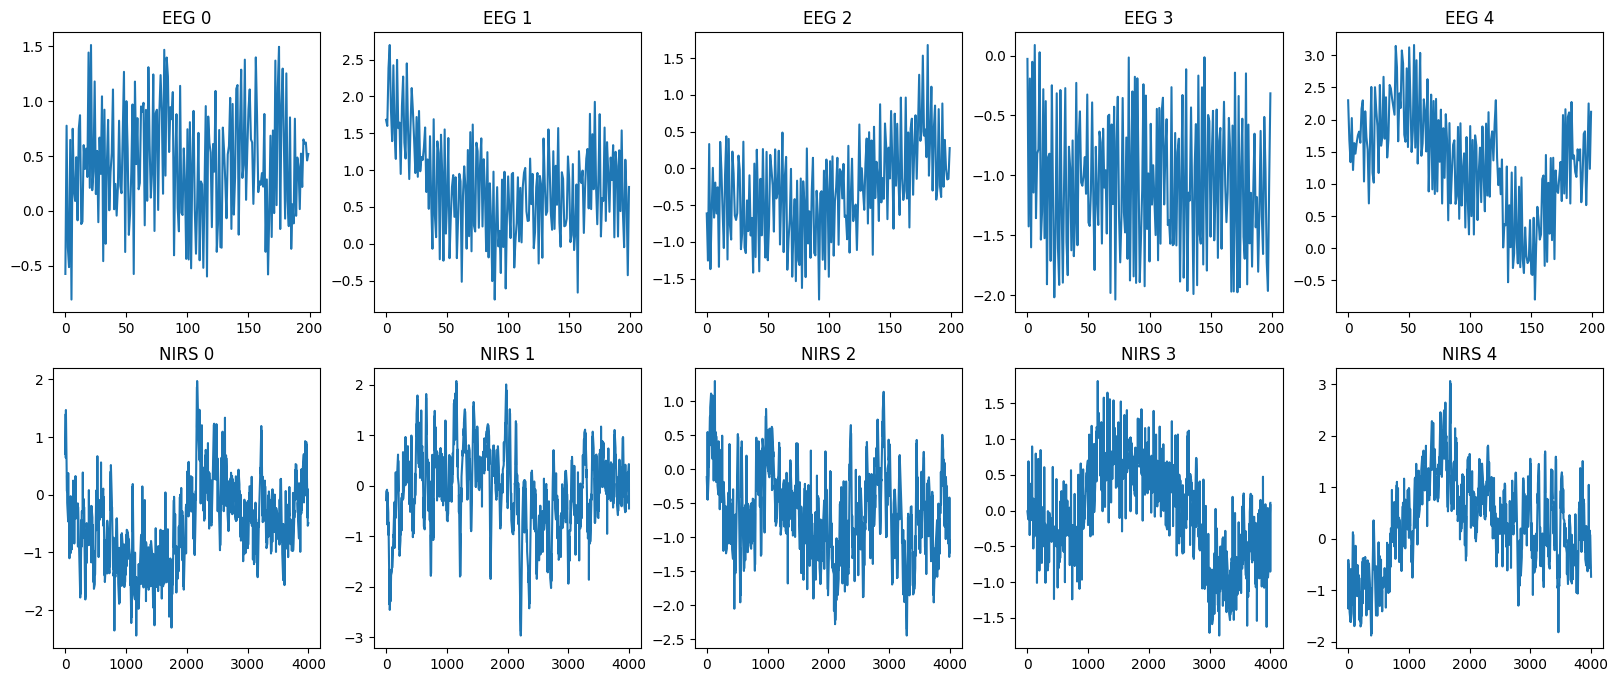

NameError: name 'sadasd' is not defined

In [5]:
def get_single_window(center_point, 
                      nirs_data, 
                      eeg_data, 
                      eeg_i_min, 
                      eeg_i_max, 
                      nirs_i_min, 
                      nirs_i_max):
    eeg_low_index = center_point + eeg_i_min
    eeg_high_index = center_point + eeg_i_max
    single_eeg_window = eeg_data[:,eeg_low_index:eeg_high_index]

    nirs_low_index = center_point + nirs_i_min
    nirs_high_index = center_point + nirs_i_max
    single_nirs_window = nirs_data[:,nirs_low_index:nirs_high_index]
    
    return single_eeg_window, single_nirs_window

def grab_ordered_windows(nirs_data,
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max):
    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    eeg_window_size = eeg_i_max - eeg_i_min

    max_center_eeg = eeg_data.shape[1] - eeg_i_max
    max_center_nirs = nirs_data.shape[1] - nirs_i_max
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min)
    min_center_nirs = np.abs(nirs_i_min)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    meta_data = []

    for i in range(min_center, max_center, eeg_window_size):
        center_point = i
        meta_data.append(center_point)
        single_eeg_window, single_nirs_window = get_single_window(center_point, 
                                                                  nirs_data, 
                                                                  eeg_data, 
                                                                  eeg_i_min, 
                                                                  eeg_i_max, 
                                                                  nirs_i_min, 
                                                                  nirs_i_max)
        
        eeg_full_windows.append(single_eeg_window)
        nirs_full_windows.append(single_nirs_window)

    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows, meta_data
    
def grab_random_windows(nirs_data, 
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max,
                        number_of_windows=1000):
    '''make number_of_windows of size t_min to t_max for each offset 0 to offset_t for eeg and nirs'''

    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    max_center_eeg = eeg_data.shape[1] - eeg_i_max
    max_center_nirs = nirs_data.shape[1] - nirs_i_max
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min)
    min_center_nirs = np.abs(nirs_i_min)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    meta_data = []
    for i in range(number_of_windows):
        center_point = np.random.randint(min_center, max_center)
        meta_data.append(center_point)
        single_eeg_window, single_nirs_window = get_single_window(center_point, 
                                                                  nirs_data, 
                                                                  eeg_data, 
                                                                  eeg_i_min, 
                                                                  eeg_i_max, 
                                                                  nirs_i_min, 
                                                                  nirs_i_max)
        
        eeg_full_windows.append(single_eeg_window)
        nirs_full_windows.append(single_nirs_window)
    
    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows, meta_data

# Pre-allocate memory for training and testing data
eeg_windowed_train = np.empty((0, eeg_lookback, len(eeg_channels_to_use)))
nirs_windowed_train = np.empty((0, fnirs_lookback, len(nirs_channels_to_use_base)))
eeg_windowed_test = np.empty((0, eeg_lookback, len(eeg_channels_to_use)))
nirs_windowed_test = np.empty((0, fnirs_lookback, len(nirs_channels_to_use_base)))

for i in subjects:
    subject_id = f'{i:02d}'

    subject_data = loadmat(os.path.join(BASE_PATH, 'matfiles', f'data_vp0{subject_id}.mat'))['subject_data_struct'][0]
    # # eeg subject_data[1][0]
    # eeg_data = []
    # for session_eeg_data in subject_data[1][0]:
    #     eeg_data.append(session_eeg_data.T)
    # eeg_data = np.hstack(eeg_data)
    # # fnirs subject_data[3][0]
    # nirs_data = []
    # for session_nirs_data in subject_data[3][0]:
    #     nirs_data.append(session_nirs_data.T)
    # nirs_data = np.hstack(nirs_data)
    # # mrk subject_data[5][0]

    eeg_data = subject_data[1][0][0].T
    nirs_data = subject_data[3][0][0].T

    assert eeg_data.shape[1] == nirs_data.shape[1]
    
    if i not in test and do_train:
        single_eeg_windowed_train, single_nirs_windowed_train, meta_data = grab_random_windows(
                     nirs_data=nirs_data, 
                     eeg_data=eeg_data,
                     sampling_rate=200,
                     nirs_t_min=nirs_t_min, 
                     nirs_t_max=nirs_t_max,
                     eeg_t_min=0, 
                     eeg_t_max=1,
                     number_of_windows=1000)

        # Append to the preallocated arrays
        single_eeg_transposed = single_eeg_windowed_train.transpose(0,2,1)
        single_nirs_transposed = single_nirs_windowed_train.transpose(0,2,1)

        single_eeg_transposed = single_eeg_transposed[:,:eeg_lookback, eeg_channel_index]
        single_nirs_transposed = single_nirs_transposed[:,:fnirs_lookback, nirs_channel_index]

        # Stack new data into the existing array, avoiding list append
        eeg_windowed_train = np.vstack((eeg_windowed_train, single_eeg_transposed))
        nirs_windowed_train = np.vstack((nirs_windowed_train, single_nirs_transposed))

        print(f'EEG Shape: {eeg_windowed_train.shape}')
        print(f'NIRS Shape: {nirs_windowed_train.shape}')

        print(f'Finished train on {subject_id}')
    elif i not in test and not do_train:
        single_eeg_windowed_train, single_nirs_windowed_train, meta_data = grab_ordered_windows(
             nirs_data=nirs_data, 
             eeg_data=eeg_data,
             sampling_rate=200,
             nirs_t_min=nirs_t_min, 
             nirs_t_max=nirs_t_max,
             eeg_t_min=0, 
             eeg_t_max=1)
        
        single_eeg_windowed_train = single_eeg_windowed_train.transpose(0,2,1)
        single_nirs_windowed_train = single_nirs_windowed_train.transpose(0,2,1)
    
        single_eeg_windowed_train = single_eeg_windowed_train[:,:eeg_lookback, eeg_channel_index]
        single_nirs_windowed_train = single_nirs_windowed_train[:,:fnirs_lookback, nirs_channel_index]
        
        # For test data, direct stacking since no windowing
        eeg_windowed_train = np.vstack((eeg_windowed_train, single_eeg_windowed_train))
        nirs_windowed_train = np.vstack((nirs_windowed_train, single_nirs_windowed_train))
    else:
        single_eeg_windowed_test, single_nirs_windowed_test, meta_data = grab_ordered_windows(
             nirs_data=nirs_data, 
             eeg_data=eeg_data,
             sampling_rate=200,
             nirs_t_min=nirs_t_min, 
             nirs_t_max=nirs_t_max,
             eeg_t_min=0, 
             eeg_t_max=1)

        single_eeg_windowed_test = single_eeg_windowed_test.transpose(0,2,1)
        single_nirs_windowed_test = single_nirs_windowed_test.transpose(0,2,1)
        
        single_eeg_windowed_test = single_eeg_windowed_test[:,:eeg_lookback, eeg_channel_index]
        single_nirs_windowed_test = single_nirs_windowed_test[:,:fnirs_lookback, nirs_channel_index]
        
        # For test data, direct stacking since no windowing
        eeg_windowed_test = np.vstack((eeg_windowed_test, single_eeg_windowed_test))
        nirs_windowed_test = np.vstack((nirs_windowed_test, single_nirs_windowed_test))
        
        print(f'Skipping {subject_id}')

print(nirs_windowed_train.shape)
print(eeg_windowed_train.shape)
print(nirs_windowed_test.shape)
print(eeg_windowed_test.shape)
# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    if i < 5:
        axs[i//5, i%5].plot(eeg_windowed_train[i,:,0])
        axs[i//5, i%5].set_title(f'EEG {i}')
    if i >= 5:
        axs[i//5, i%5].plot(nirs_windowed_train[i,:,0])
        axs[i//5, i%5].set_title(f'NIRS {i-5}')
plt.show()

### CCA Projection

In [ ]:
class EEGfNIRSData(Dataset):
    def __init__(self, fnirs_data, eeg_data):
        self.fnirs_data = fnirs_data
        self.eeg_data = eeg_data
    
    def __len__(self):
        return len(self.eeg_data)
    
    def __getitem__(self, idx):
        return self.fnirs_data[idx], self.eeg_data[idx]

def plot_series(target, output, epoch):
    plt.figure(figsize=(10, 4))
    plt.plot(target, label='Target')
    plt.plot(output, label='Output', linestyle='--')
    plt.title(f'Epoch {epoch + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = iTransformer(
    num_variates = len(nirs_channels_to_use_base),
    lookback_len = fnirs_lookback,      # or the lookback length in the paper
    target_num_variates=len(eeg_channels_to_use),
    target_lookback_len=eeg_lookback,
    dim = 256,                          # model dimensions
    depth = 6,                          # depth
    heads = 8,                          # attention heads
    dim_head = 64,                      # head dimension
    attn_dropout=0.1,
    ff_mult=4,
    ff_dropout=0.1,
    num_mem_tokens=10,
    num_tokens_per_variate = 1,         # experimental setting that projects each variate to more than one token. the idea is that the network can learn to divide up into time tokens for more granular attention across time. thanks to flash attention, you should be able to accommodate long sequence lengths just fine
    use_reversible_instance_norm = True # use reversible instance normalization, proposed here https://openreview.net/forum?id=cGDAkQo1C0p . may be redundant given the layernorms within iTransformer (and whatever else attention learns emergently on the first layer, prior to the first layernorm). if i come across some time, i'll gather up all the statistics across variates, project them, and condition the transformer a bit further. that makes more sense
)

if do_train:
    nirs_train_tensor = torch.from_numpy(nirs_windowed_train).float()
    eeg_train_tensor = torch.from_numpy(eeg_windowed_train).float()
    meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()
    
    print(nirs_train_tensor.shape)
    print(eeg_train_tensor.shape)
    
    sequence_length = eeg_train_tensor.shape[1]
    eeg_number_of_features = eeg_train_tensor.shape[2]
    nirs_number_of_features = nirs_train_tensor.shape[2]
    
    dataset = EEGfNIRSData(nirs_train_tensor, eeg_train_tensor)
    dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

    latest_epoch = 0
    loss_list = []
    if do_load:
        model_path = f'{model_name}_epoch_1.pth'

        # find the latest model
        for file in os.listdir(MODEL_WEIGHTS):
            if file.startswith(f'{model_name}_epoch_'):
                epoch = int(file.split('_')[-1].split('.')[0])
                if epoch > latest_epoch:
                    latest_epoch = epoch
                    model_path = file
        print(f'Using Model Weights: {model_path}')
        model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
        
        # load loss list
        with open(os.path.join(MODEL_WEIGHTS, f'loss_{model_name}_{latest_epoch}.csv'), 'r') as file_ptr:
            reader = csv.reader(file_ptr)
            loss_list = list(reader)[0]
        print(f'Last loss: {float(loss_list[-1])/len(dataloader):.4f}')

    # Set correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer and loss function
    optimizer = Adam(model.parameters(), lr=0.00001)
    loss_function = torch.nn.MSELoss()
    for epoch in range(latest_epoch, num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            # Forward pass
            predictions = model(X_batch)

            # Loss calculation
            loss = loss_function(predictions, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_idx+1) % 20 == 0 or batch_idx == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {loss.item():.4f}')
        
        loss_list.append(total_loss)

        if (epoch+1) % 50 == 0:
            # Save model weights
            torch.save(model.state_dict(), os.path.join(MODEL_WEIGHTS, f'{model_name}_{epoch+1}.pth'))
            with open(os.path.join(MODEL_WEIGHTS,f'loss_{model_name}_{epoch+1}.csv'), 'w', newline='') as file_ptr:
                wr = csv.writer(file_ptr, quoting=csv.QUOTE_ALL)
                wr.writerow(loss_list)
            
        # Plotting target vs. output for the first example in the last batch
        single_actual = y_batch[0, :, 0].detach().cpu().numpy()
        single_predicted = predictions[0,:,0].detach().cpu().numpy()
        r2 = r2_score(single_actual, single_predicted)
        print(f'R-squared: {r2}')
        if (epoch+1) % 10 == 0:
            plot_series(single_actual, single_predicted, epoch)

        print(f'Epoch: {epoch+1}, Average Loss: {total_loss / len(dataloader):.4f}')

torch.Size([25000, 4000, 16])
torch.Size([25000, 200, 1])


/scratch/mjm9724/conda_envs/LatestText2Dungeon/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Epoch: 1, Batch: 1, Loss: 1.1469
Epoch: 1, Batch: 20, Loss: 1.0033
Epoch: 1, Batch: 40, Loss: 0.9607
R-squared: -1.309767329883544
Epoch: 1, Average Loss: 0.9689


/scratch/mjm9724/conda_envs/LatestText2Dungeon/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Epoch: 2, Batch: 1, Loss: 0.8860
Epoch: 2, Batch: 20, Loss: 0.9054
Epoch: 2, Batch: 40, Loss: 0.8777
R-squared: -1.6323320670412715
Epoch: 2, Average Loss: 0.8666


/scratch/mjm9724/conda_envs/LatestText2Dungeon/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Epoch: 3, Batch: 1, Loss: 0.8437
Epoch: 3, Batch: 20, Loss: 0.8432
Epoch: 3, Batch: 40, Loss: 0.7829
R-squared: -1.129689289474023
Epoch: 3, Average Loss: 0.8299


/scratch/mjm9724/conda_envs/LatestText2Dungeon/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


Epoch: 4, Batch: 1, Loss: 0.8465


In [ ]:
# Perform inference on test

nirs_test_tensor = torch.from_numpy(nirs_windowed_test).float()
eeg_test_tensor = torch.from_numpy(eeg_windowed_test).float()

# Assuming fnirs_test and eeg_test are your test datasets
test_dataset = EEGfNIRSData(nirs_test_tensor, eeg_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Get weights for specific epoch
# weight_epochs = [51, 101,151,201,301,401,500,600,700,800,900,1000]
weight_epochs = [100,300,400,500]
for weight_epoch in weight_epochs:
    model_path = f'{model_name}_{weight_epoch}.pth'
    model.load_state_dict(torch.load(os.path.join(MODEL_WEIGHTS, model_path)))
    model.to(device)
    # Set model to evaluation mode
    model.eval()
    
    # Perform inference on test data
    predictions = []
    targets = []
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        predictions.append(model(X_batch).detach().cpu().numpy())
        targets.append(y_batch.detach().cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # concatenate and plot
    predictions = predictions.reshape(-1, eeg_channels)
    targets = targets.reshape(-1, eeg_channels)

    scipy.io.savemat(f'test_{model_name}_{weight_epoch}.mat', {'X': targets, 
                                                         'XPred':predictions,
                                                        'bins':10,
                                                        'scale':10,
                                                        'srate':200})
    
    # R2 score
    r2 = r2_score(targets, predictions)
    print(f'Epoch-{weight_epoch}: {r2}')
    
    # Plotting target vs. output on concatenated data
    for i in range(eeg_channels):
        plt.figure(figsize=(10, 4))
        plt.plot(targets[:,i], label='Target')
        plt.plot(predictions[:,i], label='Output', linestyle='--')
        plt.title(f'Epoch-{weight_epoch} Channel {i+1}')
        plt.legend()
        plt.grid(True)
        plt.save(f'test_{model_name}_{weight_epoch}.jpeg')



## Other

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
asd=asdsad

# class EEGfNIRS_Transformer(nn.Module):
#     def __init__(self, pos_encoder, fnirs_channels, eeg_channels, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
#         super(EEGfNIRS_Transformer, self).__init__()
#         self.fnirs_channels = fnirs_channels
#         self.eeg_channels = eeg_channels

#         # Transformer specific params
#         self.src_embed = nn.Linear(fnirs_channels, eeg_channels)
#         self.pos_encoder = pos_encoder
#         self.transformer = nn.Transformer(d_model=eeg_channels, nhead=nhead,
#                                           num_encoder_layers=num_encoder_layers,
#                                           num_decoder_layers=num_decoder_layers,
#                                           dim_feedforward=dim_feedforward,
#                                           dropout=dropout)
#         self.decoder = nn.Linear(eeg_channels, eeg_channels)

#     def forward(self, src, src_mask, tgt, tgt_mask):
#         src = self.src_embed(src)
#         src = self.pos_encoder(src)
#         tgt = self.pos_encoder(tgt)
#         output = self.transformer(src, tgt, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask)
#         output = self.decoder(output)
#         return output

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.encoding = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         self.encoding[:, 0::2] = torch.sin(position * div_term)
#         self.encoding[:, 1::2] = torch.cos(position * div_term)
#         self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', self.encoding)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return x


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class EEGfNIRS_Transformer(nn.Module):
    def __init__(self, positional_encoder, fnirs_channels, eeg_channels, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(EEGfNIRS_Transformer, self).__init__()
        self.src_embed = nn.Linear(fnirs_channels, eeg_channels)
        self.position_encoding = positional_encoder
        self.transformer = nn.Transformer(d_model=eeg_channels, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.decoder = nn.Linear(eeg_channels, eeg_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, teacher_forcing_ratio=0.5):
        src = self.src_embed(src)     
        src = self.position_encoding(src)
        tgt = self.position_encoding(tgt)
        if torch.rand(1).item() < teacher_forcing_ratio:
            output = self.transformer(src, tgt, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask, memory_key_padding_mask=memory_mask)
        else:
           output = self.autoregressive_decoder(src, tgt.shape[0])
        output = self.decoder(self.dropout(output))
        return output

    def autoregressive_decoder(self, src, tgt_len):
        device = src.device
        # Initialize the first target token (could be zeros, or another designated start symbol)
        temporary_tgt = torch.zeros(1, src.shape[1], src.shape[2], device=device)  # Start token for generation
    
        outputs = []
        for i in range(tgt_len):
            out = self.transformer(src, temporary_tgt)
            next_value = self.decoder(out[-1, :, :])  # Decode only the last output
            outputs.append(next_value)
    
            # Update temporary_tgt to only include the last generated token
            temporary_tgt = next_value.unsqueeze(0)  # Use the last output as the next input
    
        # Concatenate all outputs to form the full sequence
        outputs = torch.cat(outputs, dim=0).unsqueeze(1)  # Adding sequence dimension
        return outputs


    # def autoregressive_decoder(self, src, tgt_len):
    #     # Initialize output sequence with zeros
    #     outputs = torch.zeros(tgt_len, src.shape[1], src.shape[2], device=src.device)
    #     temporary_tgt = src.new_zeros(1, src.shape[1], src.shape[2])
    #     for i in range(tgt_len):
    #         out = self.transformer(src, temporary_tgt)
    #         next_value = self.decoder(out[-1, :, :])
    #         outputs[i] = next_value
    #         temporary_tgt = torch.cat([temporary_tgt, next_value.unsqueeze(0)], dim=0)
    #     return outputs

# Regularization and Label Smoothing
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes, smoothing=0.1):
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.cls = classes
#         self.dim = -1

#     def forward(self, pred, target):
#         pred = pred.log_softmax(dim=self.dim)
#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 1))
#             true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


In [ ]:
eeg_channels = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

positional_encoder = PositionalEncoding(eeg_channels)
positional_encoder.to(device)
model = EEGfNIRS_Transformer(positional_encoder, 
                             fnirs_channels=36, 
                             eeg_channels=eeg_channels, 
                             nhead=1, 
                             num_encoder_layers=3, 
                             num_decoder_layers=3, 
                             dim_feedforward=512, 
                             dropout=0.1)
model.to(device)

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import gc

do_train = True
do_load = False

class EEGfNIRSData(Dataset):
    def __init__(self, fnirs_data, eeg_data):
        self.fnirs_data = fnirs_data
        self.eeg_data = eeg_data
    
    def __len__(self):
        return len(self.eeg_data)
    
    def __getitem__(self, idx):
        return self.fnirs_data[idx], self.eeg_data[idx]

def plot_series(target, output, epoch):
    plt.figure(figsize=(10, 4))
    plt.plot(target, label='Target')
    plt.plot(output, label='Output', linestyle='--')
    plt.title(f'Epoch {epoch + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

def train(model, dataloader, optimizer, criterion, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        scaler = GradScaler()
        for batch_idx, (src, tgt) in enumerate(dataloader):
            src = src.to(device).transpose(0, 1).float()
            tgt = tgt.to(device).transpose(0, 1).float()

            optimizer.zero_grad()
            
            # Calculate the teacher forcing ratio for this epoch
            teacher_forcing_ratio = max(0.5 * (1 - epoch / epochs), 0.1)  # Decays from 0.5 to 0.1
            
            with autocast():
                output = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio) # tgt[:-1] excludes the last token which does not need to predict next token
                loss = criterion(output, tgt)  # tgt[1:] skips the first token which is not predicted by any input
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            torch.cuda.empty_cache()  # Free unused memory from PyTorch
            gc.collect()  # Collect garbage in Python memory management

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                
        if epoch % 10 == 0:
            # Save model weights
            torch.save(model.state_dict(), os.path.join(MODEL_WEIGHTS, f'transformer_v2_epoch_{epoch+1}.pth'))
        # Plotting target vs. output for the first example in the last batch
        plot_series(tgt[:, 0, 0].detach().cpu().numpy(), output[:, 0, 0].detach().cpu().numpy(), epoch)

        print(f'Epoch: {epoch+1}, Average Loss: {total_loss / len(dataloader):.4f}')

nirs_train_tensor = torch.from_numpy(nirs_windowed_train[:,:]).float()
eeg_train_tensor = torch.from_numpy(eeg_windowed_train[:,:,:eeg_channels]).float()
meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()

print(nirs_train_tensor.shape)
print(eeg_train_tensor.shape)

sequence_length = eeg_train_tensor.shape[1]
eeg_number_of_features = eeg_train_tensor.shape[2]
nirs_number_of_features = nirs_train_tensor.shape[2]

dataset = EEGfNIRSData(nirs_train_tensor, eeg_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

if do_load:
    model.load_state_dict(torch.load('transformer_v1_model_weights.pth'))
    device='cuda'
    model.to(device)

if do_train:
    # Assuming model has been initialized as described previously
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    num_epochs = 100
    train(model, dataloader, optimizer, criterion, epochs=num_epochs, device=device)



In [ ]:
# def infer(model, src, device, max_output_length=199):
#     model.eval()
#     src = src.to(device)  # Ensure source is on the correct device
#     src_mask = model.generate_square_subsequent_mask(sz=src.size(0)).to(device)

#     # Start with an initial target token, possibly a zero vector
#     tgt_init = torch.zeros((1, src.size(1), model.eeg_channels)).to(device)  # [time, batch, features]

#     # Memory state from the encoder to be reused in the decoding process
#     memory = model.encode(src, src_mask)

#     outputs = tgt_init
#     for _ in range(max_output_length):
#         tgt_mask = model.generate_square_subsequent_mask(outputs.size(0)).to(device)
#         out = model.decode(outputs, memory, tgt_mask)
#         next_output = out[-1, :, :].unsqueeze(0)  # Take last output and treat as next input
#         outputs = torch.cat([outputs, next_output], dim=0)  # Append to outputs
        
#         # Optional: Break if a certain condition is met (specific for the task)

#     return outputs

def infer(model, src, device, initial_tgt, max_output_length=199):
    model.eval()
    memory = src.to(device)
    outputs = initial_tgt.to(device)

    for i in range(max_output_length):
        output = model(memory, None, outputs, None)
        next_token = output[-1:]  # Get the last token produced
        outputs = torch.cat((outputs, next_token), dim=0)  # Append to the outputs

    return outputs


eeg_windowed_test, nirs_windowed_test, meta_data = grab_random_windows(
             nirs_data=nirs_test, 
             eeg_data=eeg_test,
             sampling_rate=200,
             nirs_t_min=nirs_t_min, 
             nirs_t_max=nirs_t_max,
             eeg_t_min=0, 
             eeg_t_max=1,
             number_of_windows=10)

eeg_windowed_test = eeg_windowed_test.transpose(0,2,1)
nirs_windowed_test = nirs_windowed_test.transpose(0,2,1)

nirs_test_tensor = torch.from_numpy(nirs_windowed_test[:,:,]).float()
eeg_test_tensor = torch.from_numpy(eeg_windowed_test[:,:,:5]).float()

# Assuming fnirs_test and eeg_test are your test datasets
test_dataset = EEGfNIRSData(nirs_test_tensor, eeg_test_tensor)
test_loader = dataloader #DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
actuals = []
with torch.no_grad():  # Disable gradient computation during inference
    for i, (src, tgt) in enumerate(test_loader):
        src = src[:1,:,:]
        tgt = tgt[:1,:,:]
        
        src = src.transpose(0, 1).float()  # Adjust dimensions if needed
        tgt = tgt.transpose(0, 1).float()

        initial_tgt = torch.zeros((1, src.size(1), model.eeg_channels))
        # initial_tgt = tgt[:1]

        output = infer(model, src, device, initial_tgt)
        
        predictions.append(output.squeeze(1).cpu().numpy())
        actuals.append(tgt.squeeze().cpu().numpy())

        if i % 10:
            break

predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

print(f'predictions {predictions.shape}')
print(f'actuals {actuals.shape}')

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

channels = eeg_test_tensor.shape[2]
for channel in range(channels):
    single_prediction = predictions[:,channel]
    single_actual = actuals[:,channel]
    # 'predictions' and 'actuals' arrays should be from the inference section
    r2 = r2_score(single_actual, single_prediction)
    print(f'R-squared: {r2}')
    
    # Plot the first few predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(single_actual[:200], label='Actual EEG', color='blue')  # Adjust range as needed
    plt.plot(single_prediction[:200], label='Predicted EEG', color='red')  # Adjust range as needed
    plt.title('EEG Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('EEG Signal Amplitude')
    plt.legend()
    plt.show()


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from plotly.graph_objs import *
import plotly

from random import randint


def plot_clustering_matplotlib(z_run, labels, show=True, axes=None, title=''):

    labels = labels[:z_run.shape[0]] # because of weird batch_size

    hex_colors = []
    for _ in np.unique(labels):
        hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

    colors = [hex_colors[int(i)] for i in labels]

    z_run_pca = TruncatedSVD(n_components=3).fit_transform(z_run)
    z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

    if axes is None or len(axes) < 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
    axes[0].set_title(f'{title} PCA on z_run')

    axes[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axes[1].set_title(f'{title} TSNE on z_run')
    if show:
        plt.show()
    
    return axes
    


In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA

print(eeg_windowed_train.shape)
print(nirs_windowed_train.shape)

y = eeg_windowed_train[:1000, :, 0]
x = nirs_windowed_train[:1000]
y = np.expand_dims(y, axis=2)

print(y.shape)
print(x.shape)

# Reshape the data
y_reshaped = y.reshape(y.shape[0], -1)  # Reshape to (epochs, window * EEG features)
x_reshaped = x.reshape(x.shape[0], -1)  # Reshape to (epochs, window * fNIRS features)

# Standardize the data
scaler_y = StandardScaler()
scaler_x = StandardScaler()
y_standard = scaler_y.fit_transform(y_reshaped)
x_standard = scaler_x.fit_transform(x_reshaped)

# Define the number of components
cca = CCA(n_components=50)

# Fit and transform the data
y_c, x_c = cca.fit_transform(y_standard, x_standard)

print(y_c.shape)
print(x_c.shape)

# y_c and x_c are the projections of the original EEG and fNIRS data into the shared latent space

In [ ]:
label = 0
fake_labels = np.zeros((x_c.shape[0]), dtype=int)
for i in range(0, x_c.shape[0], 100):
    for j in range(10):
        fake_labels[i+j] = label
    label += 1

# plot x and y latents side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_clustering_matplotlib(x_c, fake_labels, show=False, axes=axes[0], title='fNIRS')
plot_clustering_matplotlib(y_c, fake_labels, show=False, axes=axes[1], title='EEG')
plt.show()

In [ ]:
fake_labels = [0] * eeg_latents.shape[0]
plot_clustering(eeg_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:
fake_labels = [0] * nirs_latents.shape[0]
plot_clustering(nirs_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, sequence_length, number_of_features, hidden_dim, output_steps, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=number_of_features, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

def train_nirs_to_eeg_lstm(model, train_loader, num_epochs=10):
    model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = CorrelationLoss()
    loss_function = nn.MSELoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_data, eeg_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # Forward pass
            predictions = model(nirs_data)
            
            # Compute loss
            loss = loss_function(predictions, eeg_data)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_data.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_data.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return model

print(nirs_x_train.shape)
print(eeg_x_train.shape)
lstm_dataset = TensorDataset(nirs_x_train, eeg_x_train)
    
number_of_features = nirs_x_test.shape[2]
sequence_length = nirs_x_test.shape[1]
output_steps = eeg_x_train.shape[1]
hidden_dim = 128  # Number of LSTM units
batch_size = 500

model = LSTMModel(sequence_length=sequence_length, number_of_features=number_of_features, hidden_dim=hidden_dim, output_steps=output_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

dataloader = DataLoader(lstm_dataset, batch_size=batch_size, shuffle=True)

loss_function = nn.MSELoss()

lstm_model = train_nirs_to_eeg_lstm(model, dataloader, num_epochs=3)

In [ ]:
def predict_eeg_from_nirs_lstm(model, nirs_data):
    model.eval()
    with torch.no_grad():
        predicted_eeg = model(nirs_data)
    return predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()

nirs_predicted_eeg_lstm = predict_eeg_from_nirs_lstm(lstm_model, nirs_x_test)

epoch_to_plot = 1
size = 100

print(eeg_test_data.shape)
print(nirs_predicted_eeg_lstm.shape)

from sklearn.metrics import r2_score
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(2)
axs[0].plot(nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS LSTM')
axs[0].legend()
axs[1].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[1].legend()
plt.show()

In [ ]:
sasd=asdasdasd